In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import pydicom as dicom
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import stl as stl 
import nibabel as nib
import nrrd
import matplotlib.pyplot as plt

In [2]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    #np.save("C:/Users/shrut/Documents/CapStone" + "fullimages_.npy", volume)
    print(path,volume.shape)
    
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [3]:
# Folder "NIFTI_Target" consist of CT scans having validated  data,

print(os.getcwd())
normal_scan_paths = [
    os.path.join(os.getcwd(), "NIFTI_Target", x)
    for x in os.listdir("NIFTI_Target")
]
# Folder "NIFTI_Source" consist of CT scans that we intend to segment,

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "NIFTI_Source", x)
    for x in os.listdir("NIFTI_Source")
]

C:\Users\shrut\Documents\CapStone


In [4]:
print("CT scans of target images: " + str(len(normal_scan_paths)))
print("CT scans of source images: " + str(len(abnormal_scan_paths)))

CT scans of target images: 8
CT scans of source images: 8


In [5]:
from glob import glob
import nibabel as nib
import matplotlib.pyplot as plt


def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice.T)

def show_slice_window(slice, level, window):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")
    plt.savefig('L'+str(level)+'W'+str(window))


def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)


In [6]:
counter=1
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])



# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])


C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 1 Block.nii (512, 512, 217)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 2 Block.nii (512, 512, 154)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 3 Block.nii (512, 512, 136)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 4 Block.nii (512, 512, 141)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 5 Block.nii (512, 512, 232)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 6 Block.nii (512, 512, 168)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 7 Block.nii (512, 512, 200)
C:\Users\shrut\Documents\CapStone\NIFTI_Source\Pat 8 Block.nii (512, 512, 110)
C:\Users\shrut\Documents\CapStone\NIFTI_Target\Pat1a.nii (344, 186, 246)
C:\Users\shrut\Documents\CapStone\NIFTI_Target\Pat2a.nii (315, 169, 293)
C:\Users\shrut\Documents\CapStone\NIFTI_Target\Pat3a.nii (311, 222, 227)
C:\Users\shrut\Documents\CapStone\NIFTI_Target\Pat4a.nii (316, 221, 222)
C:\Users\shrut\Documents\CapStone\NIFTI_Target\Pat5a.nii (307, 218, 235)
C:\

In [7]:
# Split data in  training and validation.
x_train = np.concatenate((abnormal_scans[:5], normal_scans[:5]), axis=0)
y_train = np.concatenate((abnormal_labels[:5], normal_labels[:5]), axis=0)
x_val = np.concatenate((abnormal_scans[5:], normal_scans[5:]), axis=0)
y_val = np.concatenate((abnormal_labels[5:], normal_labels[5:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 10 and 6.


In [8]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    print(volume.shape)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    print(volume.shape)
    return volume, label


In [9]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(1)
)

<unknown>
(128, 128, 64, 1)


In [10]:
train=list(train_dataset)
print("Training dataset list is:",len(train))
validate=list(validation_dataset)
print("Validation dataset list is:",len(validate))

Training dataset list is: 10
Validation dataset list is: 6


Dimension of the CT scan is: (128, 128, 64, 1)


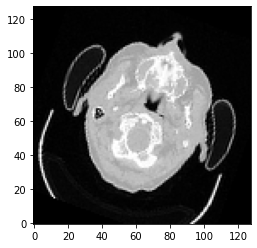

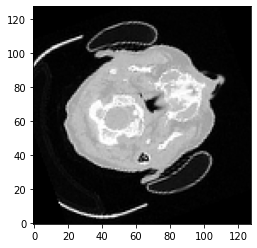

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt


def show_slice_window(slice, level, window):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")
    plt.savefig('L'+str(level)+'W'+str(window))

np.random.seed(1)  
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :,32]), cmap="gray", origin="lower")
show_slice_window(np.squeeze(image[:, :,32]),350,1400)
#########TRying to create contour#################



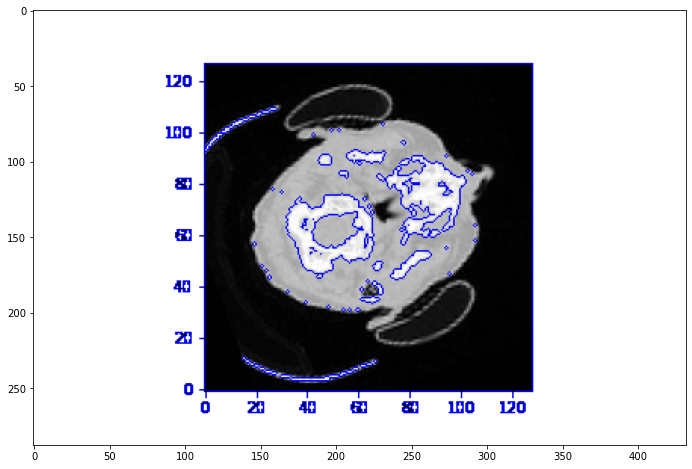

In [30]:
import cv2
image = cv2.imread('L350W1400.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
r, t = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
contours, h = cv2.findContours(t, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
cv2.drawContours(image, contours, -1, (0,0,255), thickness = 1)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.imshow(image)

In [33]:
THIN_THRESHOLD = 5
idx = 0
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    roi = image[y:y + h, x:x + w]
    if h < THIN_THRESHOLD or w < THIN_THRESHOLD:
        continue
    cv2.imwrite(str(idx) + '.png', roi)
    cv2.rectangle(image, (x, y), (x + w, y + h), (200, 0, 0), 2)
cv2.imshow('img', image)
if cv2.waitKey(0) & 0xFF == ord('q'): 
    cv2.destroyAllWindows()